In [112]:
# rl-stats-eda notebook
# Import statements
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import json
import scraper as s
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError
%matplotlib inline
#plt.style.use('ggplot')

# Define MongoDB database and collection
db_client = MongoClient('localhost', 27017)
db = db_client['rocket_league']
rl_replays = db['rl_replays']

In [2]:
s.ping_api()

200

In [3]:
data = {
        'pro': True,
    }

one = s.get_replay_list(data)

In [4]:
one_replay_id = one["list"][0]["id"]
one_replay_id

'ec445128-32a2-4ef6-9010-ace19906f27a'

In [5]:
one_replay_document = s.get_specific_replay(one_replay_id)

In [6]:
one_replay_document.keys()

dict_keys(['id', 'link', 'created', 'uploader', 'status', 'rocket_league_id', 'match_guid', 'title', 'map_code', 'match_type', 'team_size', 'playlist_id', 'duration', 'overtime', 'season', 'date', 'visibility', 'blue', 'orange', 'playlist_name', 'map_name'])

In [7]:
tmp = []

for i,rep_id in enumerate(one["list"]):
    #print(f'{i}  {rep_id}'')
    print(i)
    print(one["list"][i]["id"])
    tmp.append(one["list"][i]["id"])


#one["list"][2]["id"]

0
ec445128-32a2-4ef6-9010-ace19906f27a
1
6ff4bbc8-c733-464e-b578-a7dfb27963cd
2
3a9dcba3-06fa-405e-8dbd-9c5b0db714d0
3
d87ccaf0-fcf6-4fbd-9341-b6867dae67e1
4
777beb96-3b50-424f-9f7d-86af0c208aac
5
7529df22-a8fb-4af4-969d-90d569703d66
6
1e2b1080-9a75-4426-aea9-dab613ad2f1a
7
0a0897b5-6023-4c8d-ac7a-8ad6c74d6a88
8
95cad081-bf96-4764-9ba8-b5ae39c9453c
9
8657d11c-077e-4744-bd41-1e8bcec6da94
10
0b5b2f83-6b0d-489f-b6d9-6ac96971fd86
11
ca439e89-f620-434a-adfd-2bcf80402ff1
12
c5007de9-d203-4166-be47-2b8429ff2e94
13
84527319-21e7-4305-b246-283d49a9ad10
14
bc85def3-8c3b-4f8b-8115-5bd0bb67146c
15
80c1ec7b-9fcd-4519-8111-c70886f0b89e
16
5b0b969e-c1c7-4645-a138-bcab7611b206
17
497100d4-91e3-4193-91db-acab7426dec6
18
99860d21-3c94-4498-a888-f52d0d053775
19
54f414d5-fcd7-4655-98b8-01c50119cd7e
20
788d56f8-02e8-4bc5-9127-ebf5e680aed3
21
d84b8a4c-8365-4973-b2ec-991ef20da2cc
22
7f6bd3d9-25cd-4c49-bfe5-09ca6e4aaf70
23
858b353f-6996-4522-9724-54129a9b7933
24
f820fefa-61f5-4785-bc28-f4ecfe3972ee
25
d0af2a8

In [8]:
len(tmp)

50

### MongoDB Testing

In [12]:
"""
Currently doing in memory, but would like to send data to collection
**FOR ONE ENTRY IN NEW COLLECTION**
GAME STATS:
replay_id

PLAYER STATS (initialized with mongo):
name, car_name, goals, demo_inflicted, demo_taken
 

TEAM STATS (created from PLAYER STATS in pandas):
blue_total_goals, blue_total_demos_inflicted, blue_total_demos_taken
orange_total_goals, orange_total_demos_inflicted, orange_total_demos_taken

"""

'\nCurrently doing in memory, but would like to send data to collection\n**FOR ONE ENTRY IN NEW COLLECTION**\nGAME STATS:\nreplay_id\n\nPLAYER STATS (initialized with mongo):\nname, car_name, goals, demo_inflicted, demo_taken\n \n\nTEAM STATS (created from PLAYER STATS in pandas):\nblue_total_goals, blue_total_demos_inflicted, blue_total_demos_taken\norange_total_goals, orange_total_demos_inflicted, orange_total_demos_taken\n\n'

In [67]:
"""
Get clean data from every replay
"""

df_cols = ["blue_total_goals",
    "blue_total_demos_inflicted",
    "blue_total_demos_taken",
    "orange_total_goals",
    "orange_total_demos_inflicted",
    "orange_total_demos_taken"]

r_data = np.zeros((db.rl_replays.count(), len(df_cols)))

r_id = []


print(r_data.shape)
len(r_id)

(162, 6)


0

In [68]:
# get relevant info from database
replay_cursor = db.rl_replays.find({}, 
    {"_id":1,
    "blue":1,
    "orange":1})


In [69]:
bad_data_row_nums = []

for row,replay in enumerate(replay_cursor):
    try:
        r_id.append(str(replay['_id']))
        # Get info for Blue Team
        for player in replay["blue"]["players"]:
            r_data[row][0] += player["stats"]["core"]["goals"]
            r_data[row][1] += player["stats"]["demo"]["inflicted"]
            r_data[row][2] += player["stats"]["demo"]["taken"]
        # Get info for Orange Team
        for player in replay["orange"]["players"]:
            r_data[row][3] += player["stats"]["core"]["goals"]
            r_data[row][4] += player["stats"]["demo"]["inflicted"]
            r_data[row][5] += player["stats"]["demo"]["taken"]
    except:
        bad_data_row_nums.append(row)    # save bad rows for dropping later

print(len(bad_data_row_nums))


75


In [83]:
# quick entry/format check
print(f'first 5 of r_data.  Total length = {len(r_data)}')
print(r_data[:5])
print(f'\nfirst 5 of r_id.  Total length = {len(r_id)}')
print(r_id[:5])
print(f'\nfirst 5 of bad_data_row_nums.  Total length = {len(bad_data_row_nums)}')
print(bad_data_row_nums[:5])

first 5 of r_data.  Total length = 162
[[4. 1. 4. 3. 4. 1.]
 [0. 1. 1. 5. 1. 1.]
 [7. 0. 0. 4. 0. 0.]
 [1. 1. 1. 2. 1. 1.]
 [2. 1. 6. 1. 6. 1.]]

first 5 of r_id.  Total length = 162
['5f99c559d3221fc02865826b', '5f99c55ad3221fc02865826c', '5f99c55ad3221fc02865826d', '5f99c55bd3221fc02865826e', '5f99c55bd3221fc02865826f']

first 5 of bad_data_row_nums.  Total length = 75
[18, 20, 22, 24, 26]


In [94]:
#df = pd.DataFrame(r_data, columns=df_cols, index=r_id)
df = pd.DataFrame(r_data, columns=df_cols)
df = df.drop(bad_data_row_nums)    # dropping rows that threw exception
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 161
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blue_total_goals              87 non-null     float64
 1   blue_total_demos_inflicted    87 non-null     float64
 2   blue_total_demos_taken        87 non-null     float64
 3   orange_total_goals            87 non-null     float64
 4   orange_total_demos_inflicted  87 non-null     float64
 5   orange_total_demos_taken      87 non-null     float64
dtypes: float64(6)
memory usage: 4.8 KB


<AxesSubplot:>

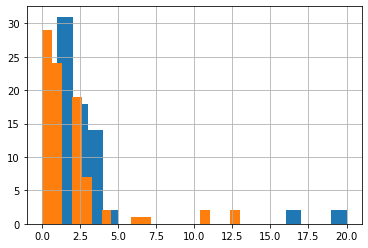

In [111]:
df['blue_total_demos_inflicted'].hist(bins=20)
df['orange_total_demos_inflicted'].hist(bins=20)

In [98]:
df.describe()

,blue_total_goals,blue_total_demos_inflicted,blue_total_demos_taken,orange_total_goals,orange_total_demos_inflicted,orange_total_demos_taken
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,3.057471,2.172414,1.747126,3.195402,1.747126,2.172414
std,1.984570,3.676471,2.629079,1.915901,2.629079,3.676471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.500000,1.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,1.000000,1.000000,3.000000,1.000000,1.000000
75%,4.000000,2.000000,2.000000,5.000000,2.000000,2.000000
max,8.000000,20.000000,13.000000,10.000000,13.000000,20.000000


In [105]:
print(df['blue_total_demos_inflicted'].value_counts())
df['orange_total_demos_inflicted'].value_counts()

1.0     31
2.0     18
0.0     18
3.0     14
20.0     2
16.0     2
4.0      2
Name: blue_total_demos_inflicted, dtype: int64


0.0     29
1.0     24
2.0     19
3.0      7
11.0     2
13.0     2
4.0      2
7.0      1
6.0      1
Name: orange_total_demos_inflicted, dtype: int64

In [113]:
def welch_test_statistic(sample_1, sample_2):
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + \
                        (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)